## Web Crawing
- 웹 페이지에서 데이터를 수집하는 방법에 대해서 학습

### 웹크롤링 방법

#### 웹페이지의 종류
- 정적인 페이지 : 웹 브라우져에 화면이 한번 뜨면 이벤트에 의한 화면의 변경이 없는 페이지 
- 동적인 페이지 : 웹 브라우져에 화면이 뜨고 이벤트가 발생하면 서버에서 데이터를 가져와 화면을 변경하는 페이지

#### requests 이용
- 받아오는 문자열에 따라 두가지 방법으로 구분
    - json 문자열로 받아서 파싱하는 방법 : 주로 동적 페이지 크롤링할때 사용 
    - html 문자열로 받아서 파싱하는 방법 : 주로 정적 페이지 크롤링할때 사용
        
#### selenium 이용
- 브라우져를 직접 열어서 데이터를 받는 방법

#### 크롤링 방법에 따른 속도
- requests json > requests html > selenium

### Crwaling Naver Stock Datas
- 네이버 증권 사이트에서 주가 데이터 수집
- 수집할 데이터 : 일별 kospi, kosdaq 주가, 일별 환율(exchange rate) 데이터
- 데이터 수집 절차
    - 웹서비스 분석 : 크롬 개발자 도구 : URL
    - 서버에 데이터 요청 : request(url) > response : json(str)
    - 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [15]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import requests

#### 1. 웹서비스 분석 : url
- pc 웹페이지가 복잡하면 mobile 웹페이지에서 수집

In [16]:
# 강사님거
page, page_size = 1, 60
url = f'https://m.stock.naver.com/api/index/KOSPI/price?pageSize={page_size}&page={page}'
print(url)

https://m.stock.naver.com/api/index/KOSPI/price?pageSize=60&page=1


In [17]:
page, page_size = 1, 20 
url = f'https://m.stock.naver.com/api/index/KOSPI/price?pageSize={page_size}&page={page}' 
print(url)

https://m.stock.naver.com/api/index/KOSPI/price?pageSize=20&page=1


#### 2. 서버에 데이터 요청 : request(url) > response : json(str)
- response의 status code가 200이 나오는지 확인
- 403이나 500이 나오면 request가 잘못되거나 web server에서 수집이 안되도록 설정이 된것임
    - header 설정 또는 selenium 사용
- 200이 나오더라도 response 안에 있는 내용을 확인 > 확인하는 방법 : response.text

In [18]:
response = requests.get(url)
response

<Response [200]>

#### 3. 서버에서 받은 데이터 파싱(데이터 형태를 변경) : json(str) > list, dict > DataFrame

In [19]:
columns = ["localTradedAt", "closePrice"]
data = response.json()
kospi_df = pd.DataFrame(data)[columns]
kospi_df.tail(2)

,localTradedAt,closePrice
18,2023-07-31,"2,632.58"
19,2023-07-28,"2,608.32"


#### 4. 함수로 만들기

In [20]:
def stock_crawling(code='KOSPI', page=1, page_size=60): 
    # 1. 웹서비스분석 : URL 
    url = f'https://m.stock.naver.com/api/index/{code}/price?pageSize={page_size}&page={page}'
    
    # 2. request(URL) > response(JSON(str)) 
    response = requests.get(url)
    
    # 3. JSON(str) > list, dict > DataFrame
    data = response.json()
    return pd.DataFrame(data)[['localTradedAt','closePrice']]

In [21]:
kospi_df = stock_crawling()
kospi_df.tail(2)


,localTradedAt,closePrice
58,2023-06-02,"2,601.36"
59,2023-06-01,"2,569.17"


In [22]:
kosdaq_df = stock_crawling('KOSDAQ')
kosdaq_df.tail(2)

,localTradedAt,closePrice
58,2023-06-02,868.06
59,2023-06-01,863.78


#### 5. 원달러 환율 데이터 수집 : 실습

In [23]:
# 1. 웹서비스분석 : URL 
code="FX_USDKRW"
page=1
page_size=60
url = f'https://m.stock.naver.com/front-api/v1/marketIndex/prices?page={page}&category=exchange&pageSize={page_size}&reutersCode={code}'

# 2. request(URL) > response(JSON(str)) 
response = requests.get(url)

# 3. JSON(str) > list, dict > DataFrame
data = response.json()['result']
columns = ["localTradedAt", "closePrice"]
pd.DataFrame(data)[columns].tail(2)

,localTradedAt,closePrice
58,2023-06-02,"1,310.00"
59,2023-06-01,"1,320.00"


In [24]:
def stock_crawling(code="FX_USDKRW", page=1, page_size=60): 
    # 1. 웹서비스분석 : URL 
    url = f'https://m.stock.naver.com/front-api/v1/marketIndex/prices?page={page}&category=exchange&pageSize={page_size}&reutersCode={code}'
    
    # 2. request(URL) > response(JSON(str)) 
    response = requests.get(url)
    
    # 3. JSON(str) > list, dict > DataFrame
    data = response.json()['result']
    columns = ["localTradedAt", "closePrice"]
    return pd.DataFrame(data)[columns]

In [25]:
usd_df = stock_crawling()
usd_df.tail(2)

,localTradedAt,closePrice
58,2023-06-02,"1,310.00"
59,2023-06-01,"1,320.00"


In [26]:
len(kospi_df), len(kosdaq_df), len(usd_df)

(60, 60, 60)

In [27]:
# 데이터분석
# 코스피, 코스닥, 원달러 환율의 상관분석
# 가설 : 코스피가 높으면 원달러 환율은 낮고, 코스피가 낮으면 원달러 환율은 높다
# 가설이 맞을시 -> 환율이 낮으면 달러를 사고, 환율이 높으면 달러를 팔아서 코스피 산다.

#### 6. 시각화

In [28]:
# 전처리 : date, kospi, kosdaq , usd 컬럼이 있는 데이터 프레임으로 변경
df = kospi_df.copy()
df.columns = ['date', 'kospi']
df['kospi'] = df['kospi'].apply(lambda data: float(data.replace(',', '')))
df['kosdaq'] = kosdaq_df['closePrice'].apply(lambda data: float(data.replace(',', '')))
df['usd'] = usd_df['closePrice'].apply(lambda data: float(data.replace(',', '')))
df.tail(2)

,date,kospi,kosdaq,usd
58,2023-06-02,2601.36,868.06,1310.0
59,2023-06-01,2569.17,863.78,1320.0


In [29]:
%config InlineBackend.figure_formats = {'png', 'retina'}

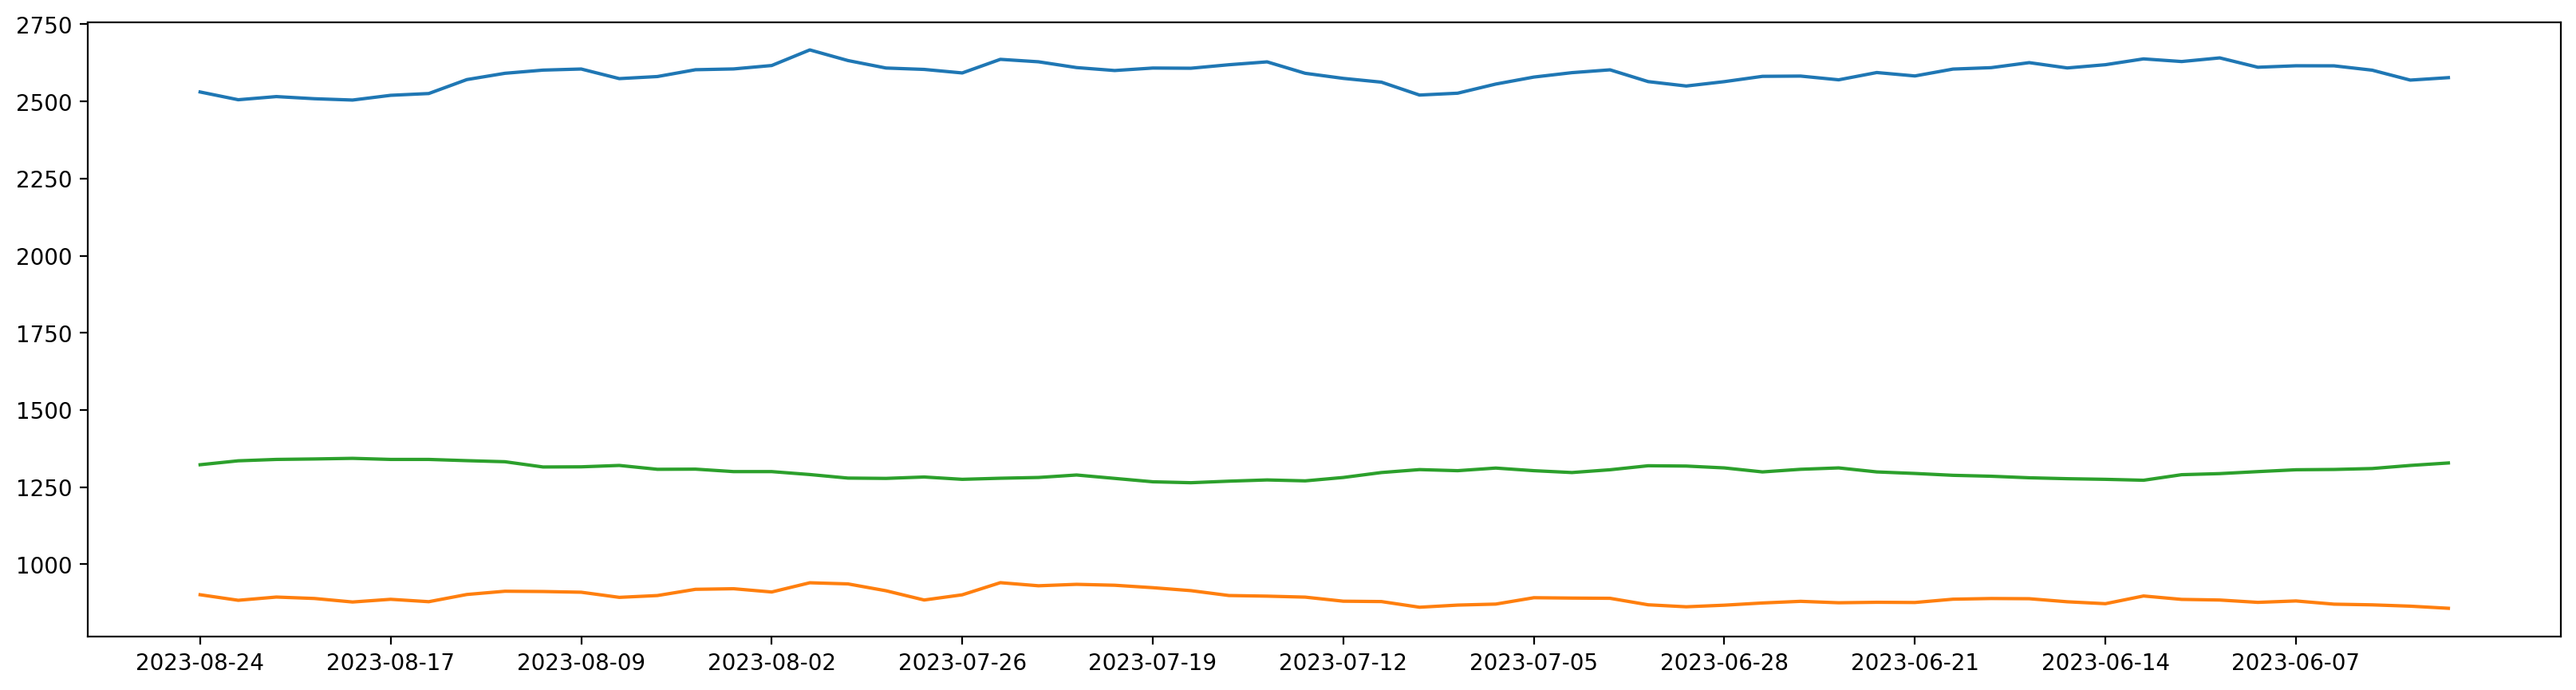

In [120]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,5))
plt.plot(df['date'], df['kospi'])
plt.plot(df['date'], df['kosdaq'])
plt.plot(df['date'], df['usd'])
plt.xticks(df['date'][::5])

plt.show()


#### 7. 데이터 스케일링
- min max scaling


- $z = \frac{x_i - min(x)}{max(x) - min(x)} (0 \leqq z \leqq 1)$


- latex syntax : `https://jjycjnmath.tistory.com/117`

In [126]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
minmax_scale(df['kospi'])

array([0.1609153 , 0.0061512 , 0.06913945, 0.02645014, 0.        ,
       0.09442086, 0.13003629, 0.40825491, 0.5336778 , 0.59703512,
       0.61893338, 0.42738513, 0.46878268, 0.60466261, 0.62059421,
       0.68874946, 1.        , 0.78784524, 0.63861721, 0.61087532,
       0.54044412, 0.81171188, 0.76293289, 0.64747493, 0.58885403,
       0.63812512, 0.63431137, 0.70431199, 0.76151812, 0.53349326,
       0.43193701, 0.35670788, 0.09964938, 0.13661807, 0.31857046,
       0.45826413, 0.54628775, 0.60263271, 0.36771852, 0.28000246,
       0.36716491, 0.47296549, 0.47794796, 0.40351848, 0.54868672,
       0.48059298, 0.61764163, 0.64587562, 0.74607861, 0.63997047,
       0.70480408, 0.82087716, 0.76797687, 0.8406225 , 0.65417974,
       0.68339792, 0.68222919, 0.59580488, 0.39779787, 0.44669988])

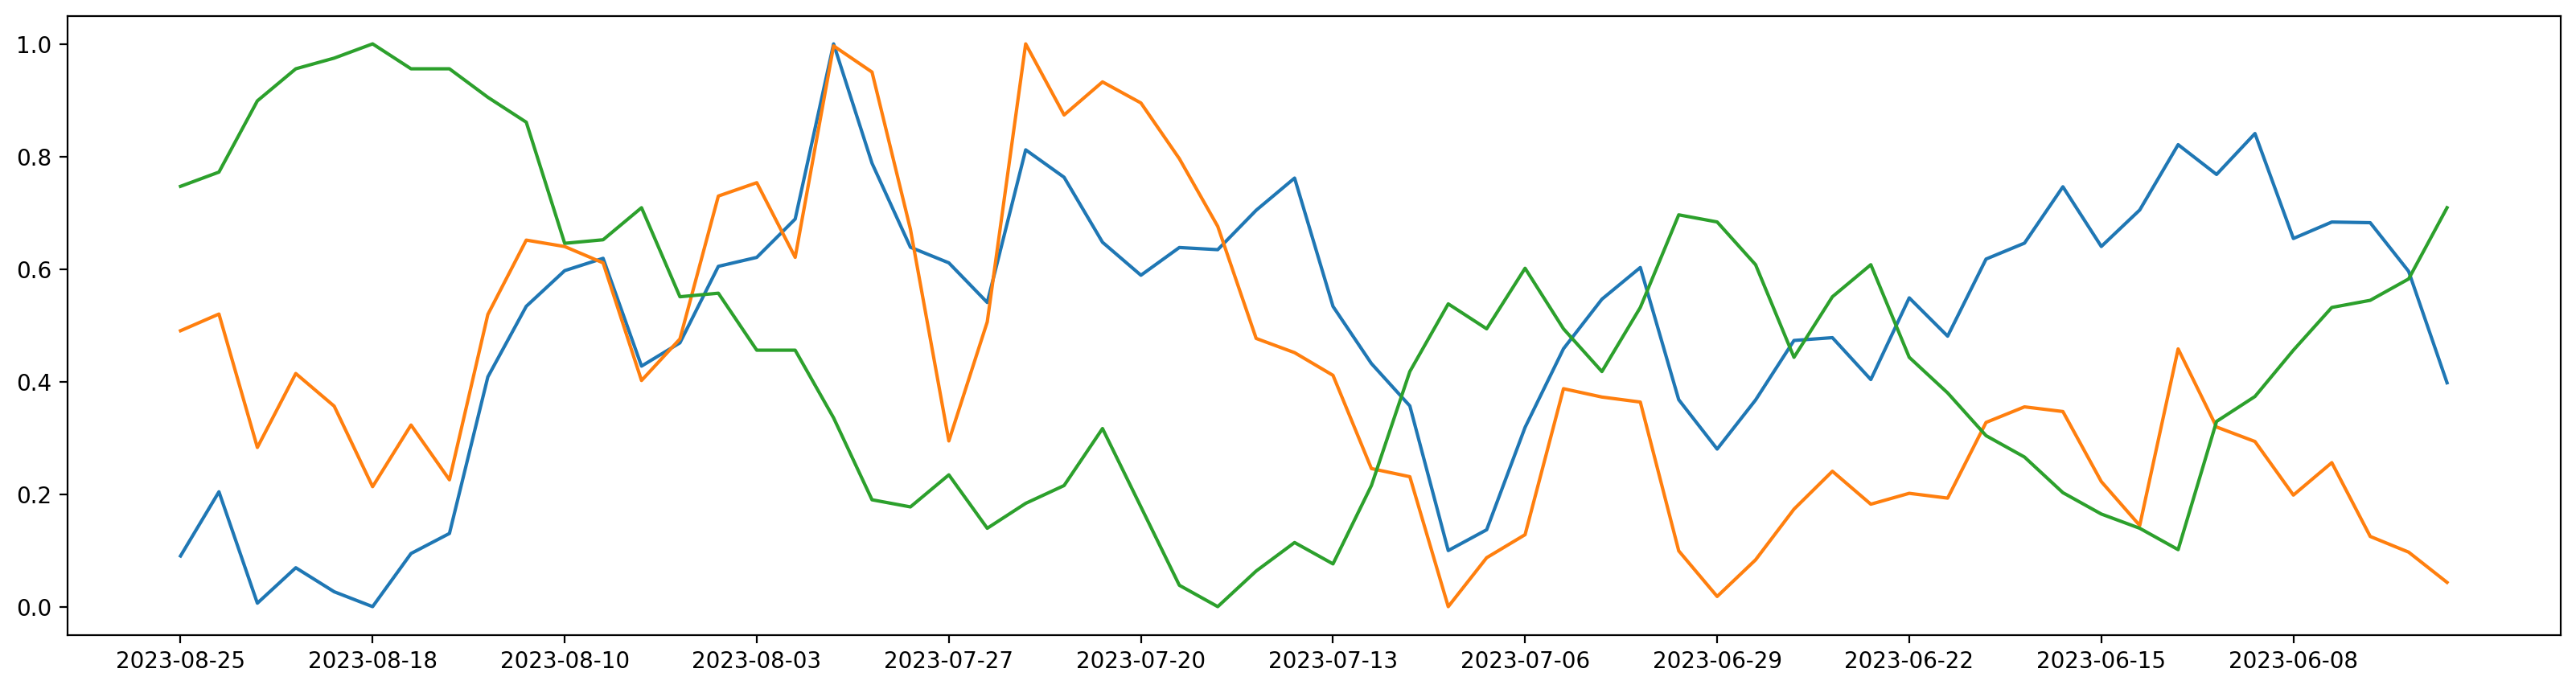

In [30]:
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(df['date'], minmax_scale(df['kospi']), label = 'kospi')
plt.plot(df['date'], minmax_scale(df['kosdaq']), label = 'kosdaq')
plt.plot(df['date'], minmax_scale(df['usd']), label = 'usd')
plt.xticks(df['date'][::5])

plt.show()


#### 8. 상관관계 분석
- 피어슨 상관계수(Pearson Correlation Coefficient)
- 두 데이터 집합의 상관도를 분석할때 사용되는 지표
- 상관계수의 해석
    - -1에 가까울수록 서로 반대방향으로 움직임
    - 1에 가까울수록 서로 같은방향으로 움직임
    - 0에 가까울수록 두 데이터는 관계가 없음

In [129]:
corr_df = df.corr()

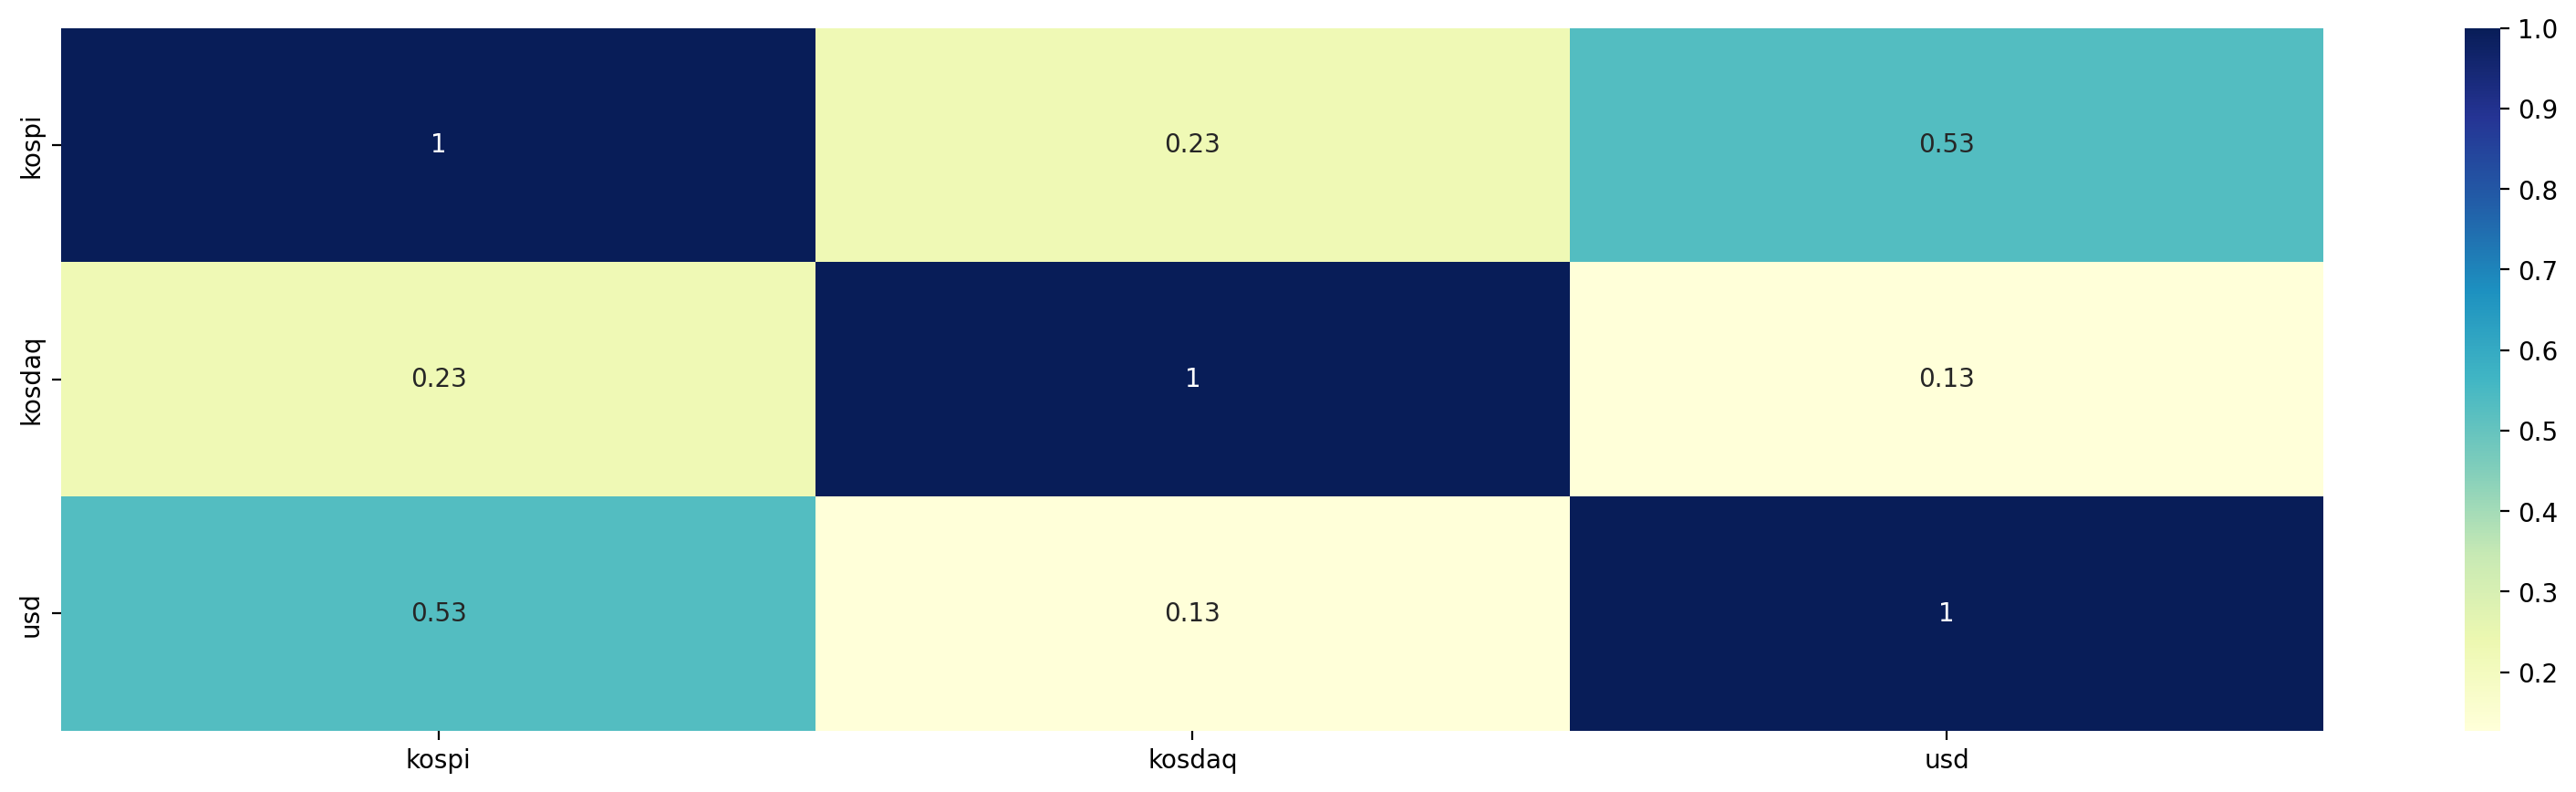

In [130]:
# 결정계수 : r-squared 
# 1과 가까울수록 강한 관계, 0과 가까울수록 약한 관계
plt.figure(figsize=(20, 5))
sns.heatmap(corr_df**2, cmap="YlGnBu", annot=True)
plt.show()

In [ ]:
# 데이터분석 
# 계획수립 # > 데이터수집(request) 
# > 데이터처리(pandas) 
# > 데이터분석(pandas,sklearn) 
# > 레포팅, 피드백(matplotlip)